In [2]:
import os
import numpy as np
import theano
import theano.tensor as T
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from layers import LSTMLayer, InputLayer, FullyConnectedLayer
from lib import get_params, make_caches, SGD, momentum
from basic_lstm import basicLSTM

In [3]:
#only visible files
def listdir_nohidden(path):
    list_files = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            list_files.append(f)
    return list_files

In [4]:
#Getting the list of files
datapath = os.path.join(os.getcwd(), 'data/LPV/')
list_files = listdir_nohidden(datapath)
#suffix = [files.split('.')[3] for files in list_files]
#Starter code when we want to use different bands for analysis
file_sel = list_files[0]
print "Processing LPV file :",file_sel

Processing LPV file : lc_1.3319.10.B.mjd


In [5]:
def acc_vel_irregular_dataset(data):
    np.random.seed()
    data_arr = np.array(data)
    err = np.array(data['Err\n'])
    err_list = []
    for er in err:
        err_list.append(np.random.normal(0,er))
    err_arr = np.array(err_list)
    time_irr = data_arr[:,0] - data_arr[0,0]
    data_mean = np.mean(data_arr[:,1])
    data_irr = data_arr[:,1] + err_arr - data_mean
    delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
    derivative = np.divide(np.diff(data_irr), np.diff(time_irr))
    magDerivative = np.lib.pad(derivative, (1,0), 'constant', constant_values=(0,0))
    dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'constant', constant_values=(0,0))
    data_mat = np.matrix([list(data_irr), delta_t, list(magDerivative), list(dDerivative)]).T
    data_mat = data_mat[:-1,:]
    resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
    time_vec = time_irr[1:]
    return data_mat, resp_mat, time_vec, data_mean

In [6]:
filepath = os.path.join(datapath, file_sel)
data = []
with open(filepath) as f:
    lines = f.readlines()
    header = [str(val) for val in lines[2].split(' ')]
    for line in lines[3:]:
        data.append([float(val) for val in line.split(' ')])
data_df = pd.DataFrame(data)
data_df.columns = header

In [7]:
data_mat, resp_mat, time_vec, data_mean = acc_vel_irregular_dataset(data_df)

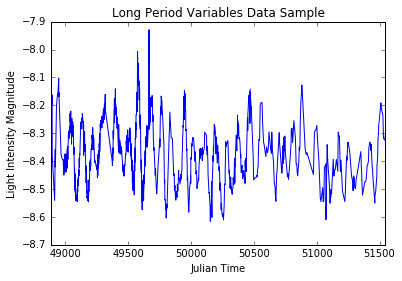

In [8]:
plt.plot(data_df['#MJD'],data_df['Mag'])
plt.title('Long Period Variables Data Sample')
plt.xlabel('Julian Time')
plt.xlim([min(data_df['#MJD']), max(data_df['#MJD'])])
plt.ylabel('Light Intensity Magnitude')

In [50]:
def plot_predicted_series(lstm_model, data_mat, resp_mat, time_vec, it_num, n_prev, base_path):
    plt.plot(time_vec, lstm_model.predict(data_mat)[0], label='Predicted' )
    plt.plot(time_vec, resp_mat,label='Actual')
    plt.title('Predicted plots for size '+str(n_prev)+' and '+str(it_num)+\
            ' training iterations')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.savefig(base_path+'predicted_n_prev_'+str(n_prev)+'_iteration_'+str(it_num)+\
            '.png')
    plt.close()

In [51]:
def plot_error(error_df, n_prev, numCells, base_path, Training=True):
    if Training == True:
        str_val = 'Training'
    else:
        str_val = 'Test'
    plt.plot(error_df.index, error_df.Error)
    plt.title(str_val+' Error variation with Iterations')
    plt.xlabel('Iterations')
    plt.ylabel(str_val+' Error')
    plt.savefig(base_path+'error_n_prev_'+str(n_prev)+'_numCellStates_'+str(numCells)+'.png')
    plt.close()

#### Different number of cell states

In [52]:
graphs_path = os.path.join(os.getcwd(),'graphs')
store_path = os.path.join(graphs_path, 'lpv-numCellStates')
pred_path = os.path.join(store_path, 'predicted-graphs')
err_path = os.path.join(store_path, 'error-graphs')
if not os.path.isdir(err_path):
    os.makedirs(err_path)
err_path = err_path + '/'

In [53]:
def train_model_CS(numCellArray, numIterations, pred_path, err_path):
    n_prev = 1
    for num in numCellArray:
        numPath = os.path.join(pred_path, str(num)+'cell_states')
        if not os.path.isdir(numPath):
            os.makedirs(numPath)
        numPath = numPath + '/'
        lstm_model = basicLSTM(4, num_cells=num)
        error_list = []
        for i in range(numIterations):
            data_mat, resp_mat, time_vec, data_mean = acc_vel_irregular_dataset(data_df)
            numSelPoints = len(data_df)
            data_mat_tr = data_mat[:numSelPoints/2,:]
            resp_mat_tr = resp_mat[:numSelPoints/2,:]
            r_cost = lstm_model.train(data_mat_tr, resp_mat_tr, 1.0)
            if (i+1)<100 and (i+1)%10 == 0:
                plot_predicted_series(lstm_model, data_mat, resp_mat,\
                    time_vec, i+1, n_prev, numPath)
            if (i+1)%100 == 0 and i<1000:
                plot_predicted_series(lstm_model, data_mat, resp_mat,\
                    time_vec, i+1, n_prev, numPath)
            if (i+1)%1000 == 0 and i > 1000:
                plot_predicted_series(lstm_model, data_mat, resp_mat,\
                    time_vec, i+1, n_prev, numPath)
            error_list.append([i+1, float(r_cost[0])])
        error_df = pd.DataFrame(np.array(error_list), columns=['Iteration','Error'])
        error_df = error_df.set_index('Iteration')
        error_df.to_csv(err_path+'error_trajectory_numcells_'+str(num)+'.csv')
        plot_error(error_df, n_prev, num, err_path)
        print "Completed for", num, "cell states"

In [54]:
numCellArray = np.arange(10, 60, 10)
numIterations = 1000

In [55]:
train_model_CS(numCellArray, numIterations, pred_path, err_path)

Completed for 10 cell states
Completed for 20 cell states
Completed for 30 cell states
Completed for 40 cell states
Completed for 50 cell states


#### Different training data percentages

In [76]:
graphs_path = os.path.join(os.getcwd(),'graphs')
store_path = os.path.join(graphs_path, 'lpv-training-percentages')
pred_path = os.path.join(store_path, 'predicted-graphs')
err_path = os.path.join(store_path, 'error-graphs')
if not os.path.isdir(err_path):
    os.makedirs(err_path)
err_path = err_path + '/'

In [77]:
def plot_error_DTP(error_df, n_prev, trp, base_path, Training=True):
    if Training == True:
        str_val = 'Training'
    else:
        str_val = 'Test'
    plt.plot(error_df.index, error_df.Error)
    plt.title(str_val+' Error variation with Iterations')
    plt.xlabel('Iterations')
    plt.ylabel(str_val+' Error')
    plt.savefig(base_path+'error_n_prev_'+str(n_prev)+'_training_perc_'+str(trp)+'.png')
    plt.close()

In [80]:
def train_model_DTP(numDivArray, numIterations, pred_path, err_path):
    n_prev = 1
    for num in numDivArray:
        numPath = os.path.join(pred_path, str(100/num)+'_training_perc')
        if not os.path.isdir(numPath):
            os.makedirs(numPath)
        numPath = numPath + '/'
        lstm_model = basicLSTM(4, num_cells=10)
        error_list = []
        for i in range(numIterations):
            data_mat, resp_mat, time_vec, data_mean = acc_vel_irregular_dataset(data_df)
            numSelPoints = len(data_df)
            data_mat_tr = data_mat[:numSelPoints/num,:]
            resp_mat_tr = resp_mat[:numSelPoints/num,:]
            r_cost = lstm_model.train(data_mat_tr, resp_mat_tr, 1.0)
            if (i+1)<100 and (i+1)%10 == 0:
                plot_predicted_series(lstm_model, data_mat, resp_mat,\
                    time_vec, i+1, n_prev, numPath)
            if (i+1)%100 == 0 and i<1000:
                plot_predicted_series(lstm_model, data_mat, resp_mat,\
                    time_vec, i+1, n_prev, numPath)
            if (i+1)%1000 == 0 and i > 1000:
                plot_predicted_series(lstm_model, data_mat, resp_mat,\
                    time_vec, i+1, n_prev, numPath)
            error_list.append([i+1, float(r_cost[0])])
        error_df = pd.DataFrame(np.array(error_list), columns=['Iteration','Error'])
        error_df = error_df.set_index('Iteration')
        error_df.to_csv(err_path+'error_trajectory_training_perc_'+str(100/num)+'.csv')
        plot_error_DTP(error_df, n_prev, 100/num, err_path)
        print "Completed for", 100/num, "% training percentages"

In [83]:
numDivArray = 1/np.arange(0.1, 0.6, 0.1)
numIterations = 5000

In [84]:
train_model_DTP(numDivArray, numIterations, pred_path, err_path)

Completed for 10.0 % training percentages
Completed for 20.0 % training percentages
Completed for 30.0 % training percentages
Completed for 40.0 % training percentages
Completed for 50.0 % training percentages
